# FICC Summative


### How to Run

all outputs are saved so you don't need to run the code. But if you want to, make sure to run each block of Python cells stored in each markdown section in this order : (1) How to Run (2) Building Trees (3) Mortgages (Fixed Rate then PTS) (4) MC

In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [7]:
#Reading in the Yield Curve Data and Processing it a bit
excel_file = pd.read_excel('yieldcurve2024 (1).xlsx', index_col= [0])
yield_curve = pd.DataFrame(excel_file.iloc[0,:]) / 100
yield_curve = yield_curve.iloc[0:20, :]
r0 = yield_curve['Yield'].to_numpy()[0]
rate_vol = 0.0173
log_vol = 0.2142
dt = 0.5

In [8]:
def array2dataframe(array):
    df = pd.DataFrame(array)
    df.index = [j for j in range(0, array.shape[0])]
    df.columns = [i for i in range(0, array.shape[1])]
    df.columns.name = 'Period: i'
    df.index.name = 'State: j'

    return df

In [9]:
def ZCB_Value_Tree(binomial_tree, dt = dt, par_value = 100):
    ''' 
    Creates value tree for a normal ZCB bond using a given binomial interest rate tree
    '''
    periods = binomial_tree.shape[0]

    #Create Empty Value Tree
    value_tree = np.zeros((periods +1) **2).reshape((periods +1) , (periods +1))   
    #Set Final Layer to Par Value
    value_tree[:, -1] = par_value

    #Backward Induction Loop
    for i in reversed(range(0, periods)):
        for j in range(0, i+1):
            value_tree[j, i] = 0.5 * (value_tree[j, i+1] + value_tree[j+1, i+1]) * np.exp(-binomial_tree[j, i] * dt)

    return value_tree

### Chapter 4 Example

Example from Chapter 4 in Veronesi's 2010 textbook about FICC 

In [63]:
#Chapter 4 Mortgage Example
BDT_Tree_Jan31 = pd.read_csv('Jan31_2000_BDT.csv', index_col = [0]) / 100
BDT_Tree_Jan31 = BDT_Tree_Jan31.to_numpy()
test_mask = array2dataframe(mortgage_value_prepay(rate = 0.07564, periods = 10, binomial_tree=BDT_Tree_Jan31)[2])
array2dataframe(mortgage_value_no_prepay(rate = 0.07564, periods = 10, binomial_tree=BDT_Tree_Jan31)[0])

Period: i,0,1,2,3,4,5,6,7,8,9,10
State: j,,,,,,,,,,,
0,102222.640128,90816.379695,80007.331533,69642.481997,59614.601627,49836.611582,40215.347374,30549.565054,20912.059785,10791.190547,0.0
1,0.000000,95316.448761,84165.230865,73362.733346,62823.562533,52481.652197,42261.615592,32005.867346,21763.990665,11142.093143,0.0
2,0.000000,0.000000,87420.895111,76276.188352,65338.300047,54550.850749,43857.594995,33133.051517,22418.893757,11408.173945,0.0
3,0.000000,0.000000,0.000000,78528.730993,67280.144349,56145.715586,45084.097384,33999.067073,22916.151493,11608.993636,0.0
4,0.000000,0.000000,0.000000,0.000000,68759.182819,57360.697897,46016.155376,34654.010022,23292.538033,11759.719747,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,58278.093846,46719.259425,35147.091692,23574.394852,11871.969427,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47248.548874,35516.398798,23784.372273,11955.962539,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35792.361014,23941.446308,12017.694570,0.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24058.212174,12064.051874,0.0


# Mortgages and MBS 

## Fixed Rate Mortgages

In [50]:
def mortgage_amortisation_schedule(rate, periods, principal = 100000):
    
    period_index = np.array([i for i in range(1,periods+1)])
    total_coupon = principal / np.sum(1/(1 + rate/2)**period_index)
    outstanding_balance = np.zeros(periods+1) #Starts at i = 0
    outstanding_balance[0] = principal
    interest_payment_schedule = np.zeros(periods) #Starts at i = 1
    principal_payment_schedule = np.zeros(periods) #Starts at i = 1
    
    for i in range(periods):
        interest_payment = outstanding_balance[i] * rate / 2
        interest_payment_schedule[i] = interest_payment
        
        principal_payment = total_coupon - interest_payment
        outstanding_balance[i+1] = outstanding_balance[i] - principal_payment
        principal_payment_schedule[i] =principal_payment
        
    #Set the i = 0 to 0 so lengths match (no cash flows at i = 0)
    interest_payment_schedule = np.insert(interest_payment_schedule,0,0)
    principal_payment_schedule = np.insert(principal_payment_schedule, 0,0)
    
    return interest_payment_schedule, principal_payment_schedule, outstanding_balance, total_coupon

In [51]:
#Mortgage without Prepayment Option
def mortgage_value_no_prepay(rate, periods,
                             dt = dt,
                             principal = 100000,
                             binomial_tree=BDT_Tree):
    ''' 
    Pricing Mortgage under HL model => assumes optimal prepayment policy. Use
    optimiser/fsolve-based strategy to find the payment rate that gives par/principal
    '''
    interest_paid, principal_paid, outstanding_principal, coupon = mortgage_amortisation_schedule(rate = rate, periods = periods, principal = principal)
    mortgage_tree_no_prepay = np.zeros([periods+1, periods+1])
    mortgage_tree_no_prepay[:, -1] = 0
    
    for i in reversed(range(0, periods)):
        for j in range(0, i + 1):
            mortgage_tree_no_prepay[j, i] = (interest_paid[i+1] + principal_paid[i+1] + 0.5 *(mortgage_tree_no_prepay[j , i + 1] + mortgage_tree_no_prepay[j+1, i+1])) * np.exp(-binomial_tree[j, i] * dt)

    
    return mortgage_tree_no_prepay, interest_paid, principal_paid, outstanding_principal, coupon

def mortgage_value_prepay(rate,
                          periods,
                          dt = dt,
                          principal = 100000,
                          binomial_tree=BDT_Tree):

    mortgage_tree_no_prepay, interest_paid, principal_paid, outstanding_principal, coupon = mortgage_value_no_prepay(rate = rate,
                                                                                                                        dt = dt, periods = periods,
                                                                                      principal = principal, binomial_tree=binomial_tree)
    Mortgage_Tree_With_Prepay = np.zeros([periods+1, periods+1])
    Prepayment_Logic = np.zeros([periods +1, periods + 1])
    for i in reversed(range(0, periods)):
        for j in range(0, i + 1):
            #Step 1. From final node we discount backwards 
            if i == periods -1:
                Value_Wait = (0.5 *(mortgage_tree_no_prepay[j , i + 1] + mortgage_tree_no_prepay[j+1, i+1])) * np.exp(-binomial_tree[j, i] * dt)
                Value_Exercise = np.maximum(0, mortgage_tree_no_prepay[j,i] - outstanding_principal[i])
            #Steps 2 & 3: Discount backwards 
            if i != periods-1:
                #Step 2 : Continuation value => discounted expected value of prior nodes
                Value_Wait = (0.5 *(Mortgage_Tree_With_Prepay[j , i + 1] + Mortgage_Tree_With_Prepay[j+1, i+1])) * np.exp(-binomial_tree[j, i] * dt)
                #Step 3 : Value of prepaying early => compare how much is left on the contract to what is left principal
                Value_Exercise = np.maximum(0, mortgage_tree_no_prepay[j,i] - outstanding_principal[i])
            #Step 4 : Check if Exercising is optimal. Assign the optimal decision
            if Value_Exercise - Value_Wait > 0:
                Mortgage_Tree_With_Prepay[j,i] = np.maximum(Value_Exercise, Value_Wait)
                Prepayment_Logic[j,i] = 1
            else:
                Mortgage_Tree_With_Prepay[j,i] = Value_Wait
            
    return Mortgage_Tree_With_Prepay, mortgage_tree_no_prepay, Prepayment_Logic



### Par Rates (Question B)

In [52]:
#HL Par Rate
par_rates = np.arange(0.055, 0.065, 0.00001)
value_rates_HL = {}
for par_rate in par_rates:
    value_rates_HL[par_rate] = mortgage_value_prepay(rate = par_rate, binomial_tree=Ho_Lee_Tree, periods = 20)[1][0,0] - mortgage_value_prepay(rate = par_rate, binomial_tree=Ho_Lee_Tree, periods = 20)[0][0,0]
    if value_rates_HL[par_rate] == 100000:
        HL_Par_Rate = par_rate
        print(f'Break even fixed mortgage rate: {par_rate.round(5)}%')
        break

print('Value of Fixed Rate Contract with No Option to Prepay : ', mortgage_value_prepay(rate = 0.06, binomial_tree=Ho_Lee_Tree, periods = 20)[1][0,0].round(2),
'\nValue of Mortgage Contract Optionality:', mortgage_value_prepay(rate = 0.06, binomial_tree=Ho_Lee_Tree, periods = 20)[0][0,0].round(2))

Break even fixed mortgage rate: 0.05964%
Value of Fixed Rate Contract with No Option to Prepay :  111305.51 
Value of Mortgage Contract Optionality: 11305.51


In [53]:
HL_Mortgage_W_Prepay, HL_Mortgage_No_Prepay, x = mortgage_value_prepay(rate = HL_Par_Rate, periods = 20, binomial_tree=Ho_Lee_Tree)
HL_Mortgage_No_Prepay[0,0] - HL_Mortgage_W_Prepay[0,0]

np.float64(100000.0)

In [54]:
#BDT Par Rate
par_rates = np.arange(0.045, 0.055, 0.00001)
value_rates_BDT = {}
for par_rate in par_rates:
    value_rates_HL[par_rate] = mortgage_value_prepay(rate = par_rate, binomial_tree=BDT_Tree, periods = 20)[1][0,0] - mortgage_value_prepay(rate = par_rate, binomial_tree=BDT_Tree, periods = 20)[0][0,0]
    if value_rates_HL[par_rate] == 100000:
        BDT_Par_Rate = par_rate
        print(f'Break even fixed mortgage rate: {par_rate.round(5)}%')
        break

print('Value of Fixed Rate Contract with No Option to Prepay : ', mortgage_value_prepay(rate = BDT_Par_Rate, binomial_tree=BDT_Tree, periods = 20)[1][0,0].round(2),
'\nValue of Mortgage Contract Optionality:', mortgage_value_prepay(rate = BDT_Par_Rate, binomial_tree=BDT_Tree, periods = 20)[0][0,0].round(2))

Break even fixed mortgage rate: 0.04996%
Value of Fixed Rate Contract with No Option to Prepay :  106204.04 
Value of Mortgage Contract Optionality: 6204.04


In [55]:
BDT_Mortgage_W_Prepay, BDT_Mortgage_No_Prepay,x  = mortgage_value_prepay(rate = BDT_Par_Rate, periods = 20, binomial_tree=BDT_Tree)
BDT_Mortgage_No_Prepay[0,0] - BDT_Mortgage_W_Prepay[0,0]

np.float64(100000.0)

## Pass Through Securities

In [56]:
def PTS_mortgage_amortisation_schedule(rate, pass_through_rate, N = 20, principal = 100000):
    
    #Builds the New Amortisation Schedules 
    periods = np.array([i for i in range(1,N+1)])
    #Calculate Coupon
    total_coupon = principal / np.sum(1/(1 + rate/2)**periods)
    #Outstanding Balance - first value is initial principal
    outstanding_balance = np.zeros(N+1) #Starts at i = 0
    outstanding_balance[0] = principal
    #Interest and PTS Interest Schedules Set-Up
    interest_payment_schedule = np.zeros(N) #Starts at i = 1
    interest_payment_schedule_pass_through = np.zeros(N)
    #Principal Schedule Set-Up
    principal_payment_schedule = np.zeros(N) #Starts at i = 1
    
    for i in range(N):
        #Interest Payments at PTS Rate
        interest_payment_pass_through = outstanding_balance[i] * pass_through_rate/2
        interest_payment_schedule_pass_through[i] = interest_payment_pass_through
        #Interest Payments at Fixed Rate
        interest_payment = outstanding_balance[i] * rate / 2
        interest_payment_schedule[i] = interest_payment
        #Principal Payment is based on fixed interest rate payments
        principal_payment = total_coupon - interest_payment
        #Same for Outstanding Balance
        outstanding_balance[i+1] = outstanding_balance[i] - principal_payment
        principal_payment_schedule[i] = principal_payment
    interest_payment_schedule_pass_through = np.insert(interest_payment_schedule_pass_through, 0, 0)
    principal_payment_schedule = np.insert(principal_payment_schedule, 0,0)
    outstanding_balance[-1] = 0
    
    return interest_payment_schedule_pass_through, principal_payment_schedule, outstanding_balance, total_coupon

#Test
test_interest, test_principal, test_outstanding, test_coupon = PTS_mortgage_amortisation_schedule(rate = 0.07564, pass_through_rate= 0.07, N = 20)

In [58]:
def PTS_Value_Tree(rate, pass_through_rate, dt = dt, periods = 20, principal = 100000, binomial_tree=Ho_Lee_Tree):
    
    #Read in PTS amortisation schedule
    interest_schedule, principal_schedule, outstanding_principal, coupon = PTS_mortgage_amortisation_schedule(rate = 
        rate, pass_through_rate=pass_through_rate, N = periods, principal = principal)
    #Create Trees for PTS, IO, PO
    PTS_Tree = np.zeros([periods+1, periods+1])
    IO_Tree = np.zeros([periods + 1, periods + 1])
    PO_Tree = np.zeros([periods+1, periods +1])
    #Mortgage Tree to get Prepayment Logic via a Prepayment Boolean Mask
    Prepayment_Logic = mortgage_value_prepay(rate = rate, binomial_tree=binomial_tree, periods = periods)[2]
    for i in reversed(range(0, periods)):
        for j in range(0, i + 1):
            #PTS Valuation 
            Value_Wait = (0.5 *(PTS_Tree[j , i + 1] + PTS_Tree[j+1, i+1]) + interest_schedule[i+1] + principal_schedule[i+1]) * np.exp(-binomial_tree[j, i] * dt)
            PTS_Tree[j,i] = np.minimum(outstanding_principal[i], Value_Wait)

            #When Prepayment Occurs 
            if Prepayment_Logic[j,i] == 1 and i != 0 and j != 0:
                #IO Strip receives no more cash flows so its value at that node = 0
                IO_Tree[j,i] = 0
                #PO Strip receives only principal and nothing else anymore
                PO_Tree[j,i] = outstanding_principal[i]
            else:
                #IO Strip and PO Strip are discounted expected values of prior nodes + CFs
                PO_Tree[j,i] = (0.5*(PO_Tree[j,i+1] + PO_Tree[j+1, i+1]) + principal_schedule[i+1]) * np.exp(binomial_tree[j,i] * - dt)
                IO_Tree[j,i] = (0.5*(IO_Tree[j, i +1] + IO_Tree[j+1, i+1]) + interest_schedule[i+1]) * np.exp(-binomial_tree[j, i] * dt)

    return PTS_Tree, IO_Tree, PO_Tree


In [59]:
''' 
Pricing using HL and BDT PTS rates
'''
HL_PTS_Rate = HL_Par_Rate - 0.005
BDT_PTS_Rate = BDT_Par_Rate - 0.005
HL_PTS_Pricing, HL_IO_Price, HL_PO_Price = PTS_Value_Tree(rate = HL_Par_Rate, pass_through_rate=HL_PTS_Rate, periods = 20, binomial_tree=Ho_Lee_Tree)
BDT_PTS_Pricing, BDT_IO_Price, BDT_PO_Price = PTS_Value_Tree(rate = BDT_Par_Rate, pass_through_rate=BDT_PTS_Rate, periods = 20, binomial_tree=BDT_Tree)
print(f'Pass Through Rates : HL PTS Rate = {HL_PTS_Rate.round(5)}%', f'\nBDT PTS Rate = {BDT_PTS_Rate.round(5)}%')

Pass Through Rates : HL PTS Rate = 0.05464% 
BDT PTS Rate = 0.04496%


In [60]:

#Price of PTS Under Both Trees
print(f'HL Tree: {HL_PTS_Pricing[0,0].round(2)} and BDT Tree: {BDT_PTS_Pricing[0,0].round(2)}')

#Price of IO Strips Under Both Trees
print(f'HL Tree: {HL_IO_Price[0,0].round(2)} and BDT Tree: {BDT_IO_Price[0,0].round(2)}')

#Price of PO Strip under Both Trees
print(f'HL Tree: {HL_PO_Price[0,0].round(2)} and BDT Tree: {BDT_PO_Price[0,0].round(2)}')


HL Tree: 99325.33 and BDT Tree: 99353.57
HL Tree: 7203.09 and BDT Tree: 5537.74
HL Tree: 92138.88 and BDT Tree: 93846.89


# Building Trees

In [10]:
def Building_Tree(theta,
                  number_of_periods = yield_curve['Yield'].to_numpy().shape[0],
                  r0 = r0,
                  volatility = rate_vol,
                  dt = dt):

 
 #Creating Binomial Tree of length i, height i 
 binomial_tree = np.zeros((number_of_periods , number_of_periods))
 binomial_tree[np.triu_indices(number_of_periods, 0)] = r0
 
 #Apply Ho-Lee
 for i in range(1, number_of_periods): #Time steps from i = 1,2, ... N-1
      for j in range(i + 1):      #States from 0 to i 
            if j == 0:
                previous_rate = binomial_tree[j, i-1]
                binomial_tree[j , i] = previous_rate + theta[i-1]*dt + volatility*np.sqrt(dt)
            else:
                previous_rate = binomial_tree[j-1, i-1]
                binomial_tree[j, i] = previous_rate + theta[i-1]*dt - volatility*np.sqrt(dt)

 return binomial_tree

In [11]:
#Section 1.2
def Building_Tree_HL_BDT(theta, pricing_model, volatility,
                  number_of_periods = 20,
                  r0 = r0,
                  dt = dt):

 
 #Creating Binomial Tree of length i, height i 
 binomial_tree = np.zeros((number_of_periods , number_of_periods))
 
 if pricing_model == 'HL':
        binomial_tree[0,0] = r0
        for i in range(1, number_of_periods): #Time steps from i = 1,2, ... N-1
            for j in range(i + 1):      #States from 0 to i 
                if j == 0:
                    previous_rate = binomial_tree[j, i-1]
                    binomial_tree[j , i] = previous_rate + theta[i-1]*dt + volatility*np.sqrt(dt)
                else:
                    previous_rate = binomial_tree[j-1, i-1]
                    binomial_tree[j, i] = previous_rate + theta[i-1]*dt - volatility*np.sqrt(dt)
        return np.triu(binomial_tree)
 
 if pricing_model == 'BDT':
        binomial_tree[0,0] = np.log(r0)  #Initial interest rate is the log of r0
        for i in range(1, number_of_periods): #Same Logic as HL Tree
            for j in range(i + 1):
                if j == 0:
                    previous_rate = binomial_tree[j, i -1]
                    binomial_tree[j,i] = previous_rate + theta[i-1] * dt + volatility*np.sqrt(dt)
                else:
                    previous_rate = binomial_tree[j-1, i-1]
                    binomial_tree[j,i] = previous_rate + theta[i-1]*dt - volatility*np.sqrt(dt)
        binomial_tree = np.exp(binomial_tree)
        return np.triu(binomial_tree)



In [12]:
#Section 1.1
def ZCB(yield_curve=yield_curve['Yield'].to_numpy(),
        dt = dt,
        periods = 20):
    '''  
    Construction of ZCB Prices
    '''
    #Construct Empty Array 
    ZCB_prices = np.zeros(periods)
    
    #Loop over Each Period
    for i in range(periods):
        discount_factor = np.exp( - yield_curve[i] * (dt*(i+1)))
        ZCB_prices[i] = 100.00 * discount_factor
    
    return ZCB_prices


In [13]:
#Section 1.3
def ZCB_Pricing(binomial_tree, dt = dt, par_value = 100, test=False):
    ''' 
    To calibrate Ho-Lee model, we use backward induction to calculate the price of ZCB bonds.
    This function will be passed through to an optimiser, we can minimise some loss function by comparing this to the true observed
    ZCB prices. This function manually sets the final layer based on the payoff

    Risk neutral probabilities uses q = 0.5
    Parameters :
        1. binomial_tree : Takes in binomial tree from Error Function => Saves time for optimisation
                - Binomial Tree is number of periods x number of periods (includes i = 0)
                - Value tree should have same dimensions but last period (i = maturity) is pay off
        3. dt : set to 0.5 years
        4. par value : $100 ZCB 
    ----------
    Returns ZCB_price : present value of cash flows e.g., price of ZCB bond at t = 0
    
    '''

    Model_Prices = []    

    
    for _maturity in reversed(range(0, binomial_tree.shape[0])): #Loops through each maturity (starts at N - 1)
        #Create Value Tree and set last row to $100
        value_tree = np.zeros((_maturity +1) **2).reshape((_maturity +1) , (_maturity +1))                            
        #Sets penultimate node for each maturity
        a = binomial_tree[:, _maturity]
        a = a[a != 0]
        value_tree[:,-1] = par_value * np.exp(-a * dt)                      
        #Backward Induction : start from final node, go backwards to i = 0 period
        for i in range(_maturity-1, -1, -1):

            #Only goes up to when i = j (diagonal)
            for j in range(i+1): 
                #Discounted Expected Value of the bond at time i
                value_tree[j, i] = 0.5 * (value_tree[j, i+1] + value_tree[j+1, i+1]) * np.exp(-binomial_tree[j, i] * dt)

        Model_Prices.append(value_tree[0,0])

    Model_Prices.sort(reverse=True)
    return (Model_Prices)

In [14]:
def Ho_Lee_Model_LossFunction(theta, periods = 20, r0 = r0, volatility = rate_vol, dt = dt, 
                              yield_curve = yield_curve['Yield'].to_numpy()):
    '''  
    This calculates the error function between the Ho-lee model (using initial theta values that 
    are basically random values) and the actual observed ZCB prices calculated from ZCB() function.

    The idea is to use this function in tandem with an optimiser that will fit the theta values by
    minimising this loss function.

    Not the most computationally efficient method but shows the information flow well.

    Loss function used is MSE.
    Uses the short-rate at time = 0 as an initial value (r0)
    '''

    #Get all the ZCB Prices that we are fitting to
    ZCB_observed = ZCB(yield_curve=yield_curve, periods = periods) 
    binomial_tree = Building_Tree_HL_BDT(pricing_model='HL', volatility = volatility, theta = theta, number_of_periods=periods, r0 = r0)

    target_model_price = ZCB_Pricing(binomial_tree = binomial_tree)
    Error_SSE = ((target_model_price - ZCB_observed) ** 2).sum()
    
    return Error_SSE

def calibration_HL(yield_curve = yield_curve.to_numpy(), periods = 20, sigma = rate_vol, dt = dt, r0 = r0):
    ''' 
    argmin theta vector of norm-2 errors 

    '''
    initial_guess_theta = np.zeros(periods-1) * 0.01

    #objective function 
    def objective_function(theta):
        return Ho_Lee_Model_LossFunction(theta=theta, periods = periods, r0 = r0, yield_curve=yield_curve)
    
    result = minimize(objective_function, initial_guess_theta, method = 'BFGS')
    print(result.success, result.message)

    theta_calibrated = result.x

    return theta_calibrated, result


In [15]:
def BDT_Model_LossFunction(theta, periods = 20, r0 = r0, volatility = log_vol, dt = dt, 
                              yield_curve = yield_curve):
    '''  
    This calculates the error function between the Ho-lee model (using initial theta values that 
    are basically random values) and the actual observed ZCB prices calculated from ZCB() function.

    The idea is to use this function in tandem with an optimiser that will fit the theta values by
    minimising this loss function.

    Not the most computationally efficient method but shows the information flow well.

    Loss function used is MSE.
    Uses the short-rate at time = 0 as an initial value (r0)
    '''

    #Get all the ZCB Prices that we are fitting to
    ZCB_observed = ZCB(yield_curve=yield_curve, periods = periods) 
    binomial_tree = Building_Tree_HL_BDT(theta=theta, r0 = r0, number_of_periods=periods, volatility = volatility, pricing_model='BDT')

    target_model_price = ZCB_Pricing(binomial_tree = binomial_tree)
    Error_SSE = ((target_model_price - ZCB_observed) ** 2).sum()
    
    return Error_SSE

def calibration_BDT(yield_curve, periods = 20, sigma = log_vol, dt = dt, r0 = r0):
    ''' 
    argmin theta vector of norm-2 errors 

    '''
    initial_guess_theta = np.zeros(periods-1) * 0.01

    #objective function 
    def objective_function(theta):
        return BDT_Model_LossFunction(theta=theta, periods = periods, r0 = r0, yield_curve=yield_curve)
    
    result = minimize(objective_function, initial_guess_theta, method ='BFGS')
    print(result.success, result.message)

    theta_calibrated = result.x

    return theta_calibrated, result

### Ho Lee & BDT Interest Rate Models

### Ho-Lee Calibration

In [16]:
''' 
Ho-Lee Model Calibration results give us this array of theta values. As we can see, the loss function is on the e-

'''

HL_Calibration_Thetas = [-0.01352538, -0.00377533, -0.00042592,  0.00052368,  0.00067321,
        0.00062275, -0.00022782,  0.00172153,  0.00247086,  0.00102001,
        0.00116912,  0.00391809,  0.00186691,  0.00501563,  0.00256417,
        0.00271257,  0.00286078,  0.00300883,  0.00715665]

#Build Tree
Ho_Lee_Tree = Building_Tree_HL_BDT(pricing_model='HL', theta = HL_Calibration_Thetas, number_of_periods=20, r0 = r0, volatility=rate_vol)


#Check Loss Function of HL-Calibrated ZCB Prices
Ho_Lee_Model_LossFunction(theta = HL_Calibration_Thetas, periods = 20, r0 = r0)

np.float64(2.1225058293122246e-10)

In [17]:
HL_Calibrated_Thetas, HL_Calibration_Results = calibration_HL(periods = 20)

C:\Users\Phillip\AppData\Local\Temp\ipykernel_19068\3769367299.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZCB_prices[i] = 100.00 * discount_factor


False Desired error not necessarily achieved due to precision loss.


C:\Users\Phillip\AppData\Local\Temp\ipykernel_19068\3769367299.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZCB_prices[i] = 100.00 * discount_factor


In [18]:
HL_Calibrated_Thetas

array([-0.01352538, -0.00377533, -0.00042592,  0.00052368,  0.00067321,
        0.00062275, -0.00022782,  0.00172153,  0.00247086,  0.00102001,
        0.00116912,  0.00391809,  0.00186691,  0.00501563,  0.00256417,
        0.00271257,  0.00286078,  0.00300883,  0.00715665])

### Simple BDT Calibration

In [19]:
'''
Calibration of BDT Tree returns the below theta values. The error function also shows a good fit with an MSE on order of magnitude of ...
'''

BDT_Calibrated_Thetas = [-0.35166895, -0.12973433, -0.04314289, -0.01995331, -0.01908645,
       -0.023834  , -0.05145382,  0.0006386 ,  0.01834071, -0.02568041,
       -0.0248346 ,  0.04874259, -0.01129887,  0.07052889,  0.00182588,
        0.00292366,  0.00402355,  0.00514153,  0.10679238, -0.0870087 ,
        0.11756801, -0.09304293,  0.12812763, -0.0988221 ,  0.13846138,
       -0.10437622,  0.14856368, -0.1097322 ,  0.01768505,  0.01877134,
        0.01985832,  0.02092173,  0.02197149,  0.02299795, -0.15372942,
        0.19492528,  0.02599841, -0.16412195,  0.01490003,  0.21619626,
       -0.17494786,  0.01720672,  0.01795217,  0.0186364 ,  0.01934527,
        0.02001716,  0.02066254,  0.02130269, -0.2523553 ]


BDT_Tree = Building_Tree_HL_BDT(theta = BDT_Calibrated_Thetas, pricing_model='BDT', number_of_periods=20, r0 = r0, volatility=log_vol)

BDT_Model_LossFunction(theta=BDT_Calibrated_Thetas, periods = 20, r0 = r0, yield_curve=yield_curve['Yield'].to_numpy())

np.float64(5.468836095840122e-12)

In [20]:
BDT_Calibrated_Thetas, BDT_Results = calibration_BDT(yield_curve=yield_curve['Yield'].to_numpy(), periods = 20, sigma = log_vol, r0 = r0)

True Optimization terminated successfully.


### Testing (based on Veronsi 2011)


In [21]:
test_maturity = [i * 0.5 for i in range(1,12)]
test_price = [99.1338, 97.8925, 96.1462, 94.1011, 91.7136, 89.2258, 86.8142, 84.5016, 82.1848, 79.7718, 77.4339]
test_yields = [1.74, 2.13, 2.62, 3.04, 3.46, 3.80, 4.04, 4.21, 4.36, 4.52, 4.65]
test_yields = np.array(test_yields) / 100

HL_thetas_Veronsi = [0.015675, 0.021824, 0.014374, 0.017324, 0.007873, 0.000423, -0.000628, 0.004322, 0.009271, 0.001202]
BDT_thetas_Veronsi = [0.7182, 0.6916, 0.3348, 0.3379, 0.1182, -0.0230, -0.0438, 0.0455, 0.1281, -0.0126]

### Ho Lee & BDT Testing

In [22]:
#The ZCB prices on Jan 8 2002 yields by HL model is calibrated
ZCB_Pricing(binomial_tree=
            Building_Tree_HL_BDT(theta = HL_thetas_Veronsi, r0 = 0.0174, number_of_periods=11,
                                 pricing_model='HL', volatility=rate_vol))

[np.float64(99.13377354877926),
 np.float64(97.8925199386555),
 np.float64(96.1462252342918),
 np.float64(94.10115336419449),
 np.float64(91.71356656896344),
 np.float64(89.22581300642932),
 np.float64(86.81421561300095),
 np.float64(84.50159655485554),
 np.float64(82.1847992420609),
 np.float64(79.77181542525089),
 np.float64(77.43389845384934)]

In [23]:
#Same for BDT
ZCB_Pricing(binomial_tree=
            Building_Tree_HL_BDT(theta = BDT_thetas_Veronsi, r0 = 0.0174, number_of_periods=11,
                                 pricing_model='BDT', volatility=log_vol))

[np.float64(99.13377354877926),
 np.float64(97.89251115240728),
 np.float64(96.14619487906887),
 np.float64(94.10112103555397),
 np.float64(91.71356114129568),
 np.float64(89.22581444604727),
 np.float64(86.8142650682546),
 np.float64(84.50169495072147),
 np.float64(82.18495319871649),
 np.float64(79.77198342904671),
 np.float64(77.43406589895683)]

In [24]:
#Optimiser to find Thetas work 
HL_Veronsi_Calibrated_Thetas, HL_V_Result = calibration_HL(yield_curve=test_yields, periods = 11, r0 = 0.0174 )
BDT_Veronsi_Calibrated_Thetas, BDT_V_Result = calibration_BDT(yield_curve=test_yields, periods = 11, r0 = 0.0174)

True Optimization terminated successfully.
True Optimization terminated successfully.


In [25]:
#Error Function (MSE) confirms HL model pricing is accurate
Ho_Lee_Model_LossFunction(theta = HL_Veronsi_Calibrated_Thetas, periods = 11, r0 = 0.0174, yield_curve=test_yields)

np.float64(2.777278530248302e-11)

In [26]:
#Error Function also confirms BDT model is accurate
BDT_Model_LossFunction(theta = BDT_Veronsi_Calibrated_Thetas, periods = 11, r0 = 0.0174, volatility = log_vol, yield_curve = test_yields)

np.float64(2.3584272854215594e-12)

# Monte Carlo

### Interest Rate MC (Qd)

In [35]:
N = 100000
def monte_carlo_simulation(tree, paths=N):
    #Create simulation table (number of periods x number of simulations)
    simulation = np.zeros([paths, tree.shape[0]])
    #Set the initial node to interest rate at i = 0
    simulation[:, 0] = tree[0,0]
    #Loop over each simulation
    for path in range(0, simulation.shape[0]):
        rate = 0
        p = 0
        counter = 0

        for period in range(1, simulation.shape[1]):
            p = np.random.rand() #Random engine

            if p > 0.5: #Up move 
                simulation[path, period] = tree[rate, counter + 1]
                rate = rate
                counter += 1
            else:
                simulation[path, period] = tree[rate, counter + 1]
                rate = rate + 1
                counter += 1
    
    return simulation

In [36]:
#BDT Monte Carlo Simulation of Interest Rate Tree
MC_BDT = pd.DataFrame(monte_carlo_simulation(tree = BDT_Tree))
#Ho-Lee Monte Carlo Simulation of Interest Rate Tree
MC_HL = pd.DataFrame(monte_carlo_simulation(tree = Ho_Lee_Tree))


In [37]:
#Index and Columns
MC_BDT.index = np.arange(0, N)
MC_BDT.index.name = 'Simulations'
MC_BDT.columns.name = 'Period'
MC_HL.index = np.arange(0, N)
MC_HL.index.name = 'Simulations'
MC_HL.columns.name = 'Periods'
#Interest Rate Realisations at i = 20
MC_BDT_Realisations = MC_BDT.iloc[:, -1]
MC_HL_Realisations = MC_HL.iloc[:, -1]

<Axes: title={'center': 'Ho-Lee : Monte Carlo Simulation of 100000 Runs'}, xlabel='Interest Rate', ylabel='Number of Occurences'>

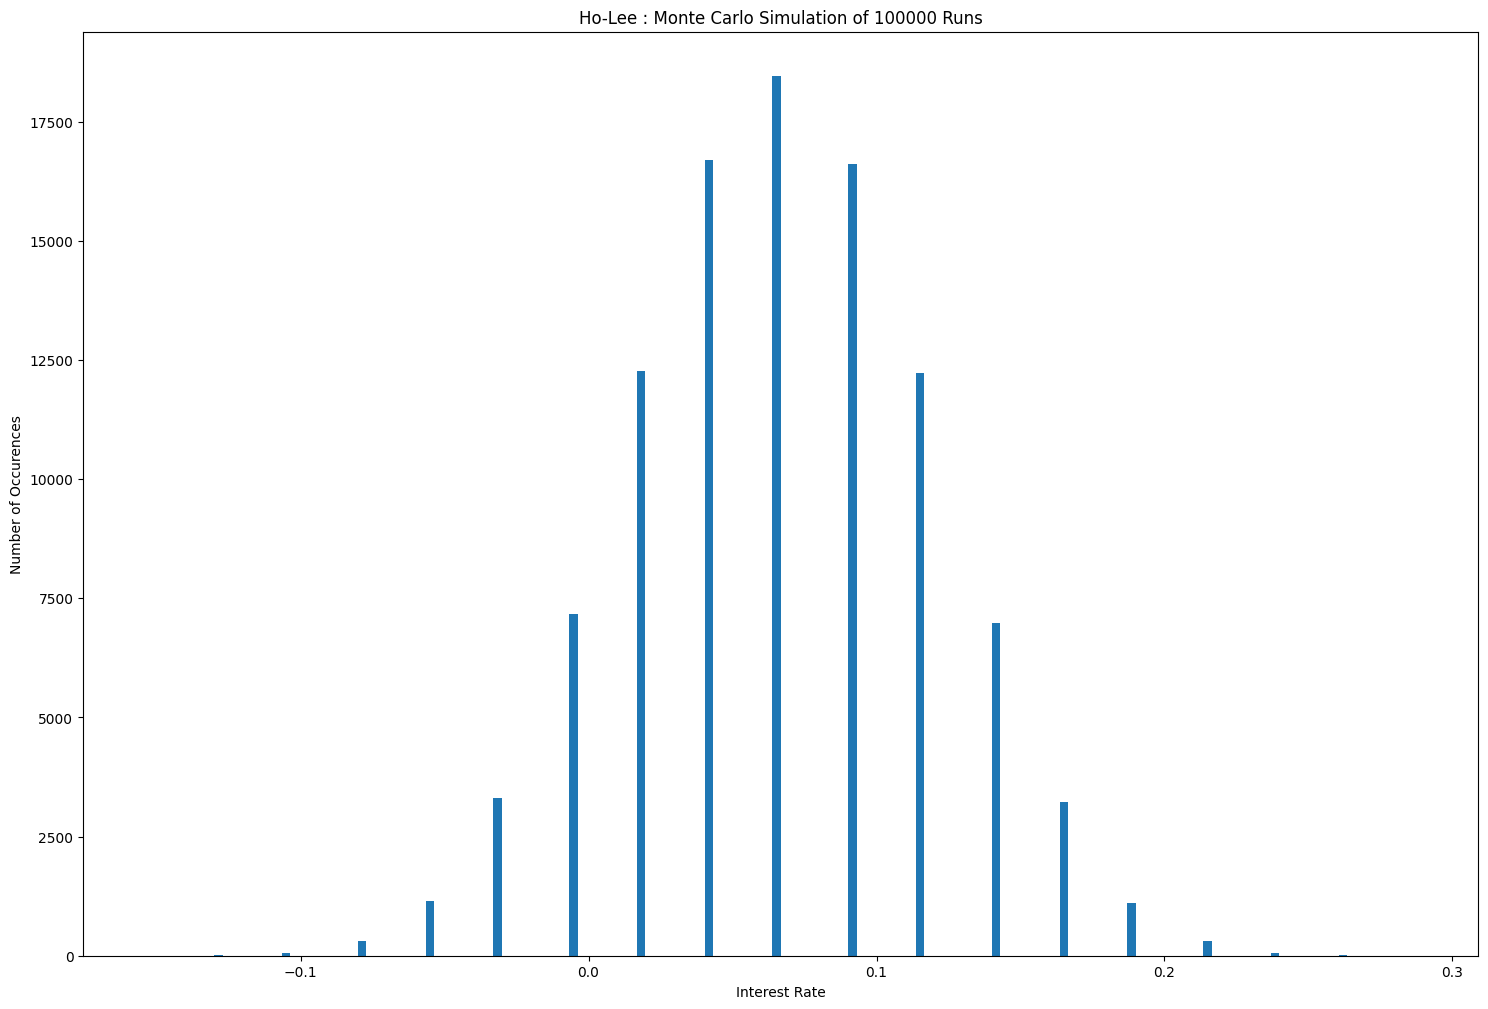

In [38]:
MC_HL_Realisations.plot.hist(
    figsize = (18, 12),
    xlabel = 'Interest Rate',
    ylabel= 'Number of Occurences',
    bins=150,
    title = f'Ho-Lee : Monte Carlo Simulation of {N} Runs')

<Axes: title={'center': 'Monte Carlo Simulation of 100000 Runs'}, xlabel='Interest Rate', ylabel='Number of Occurences'>

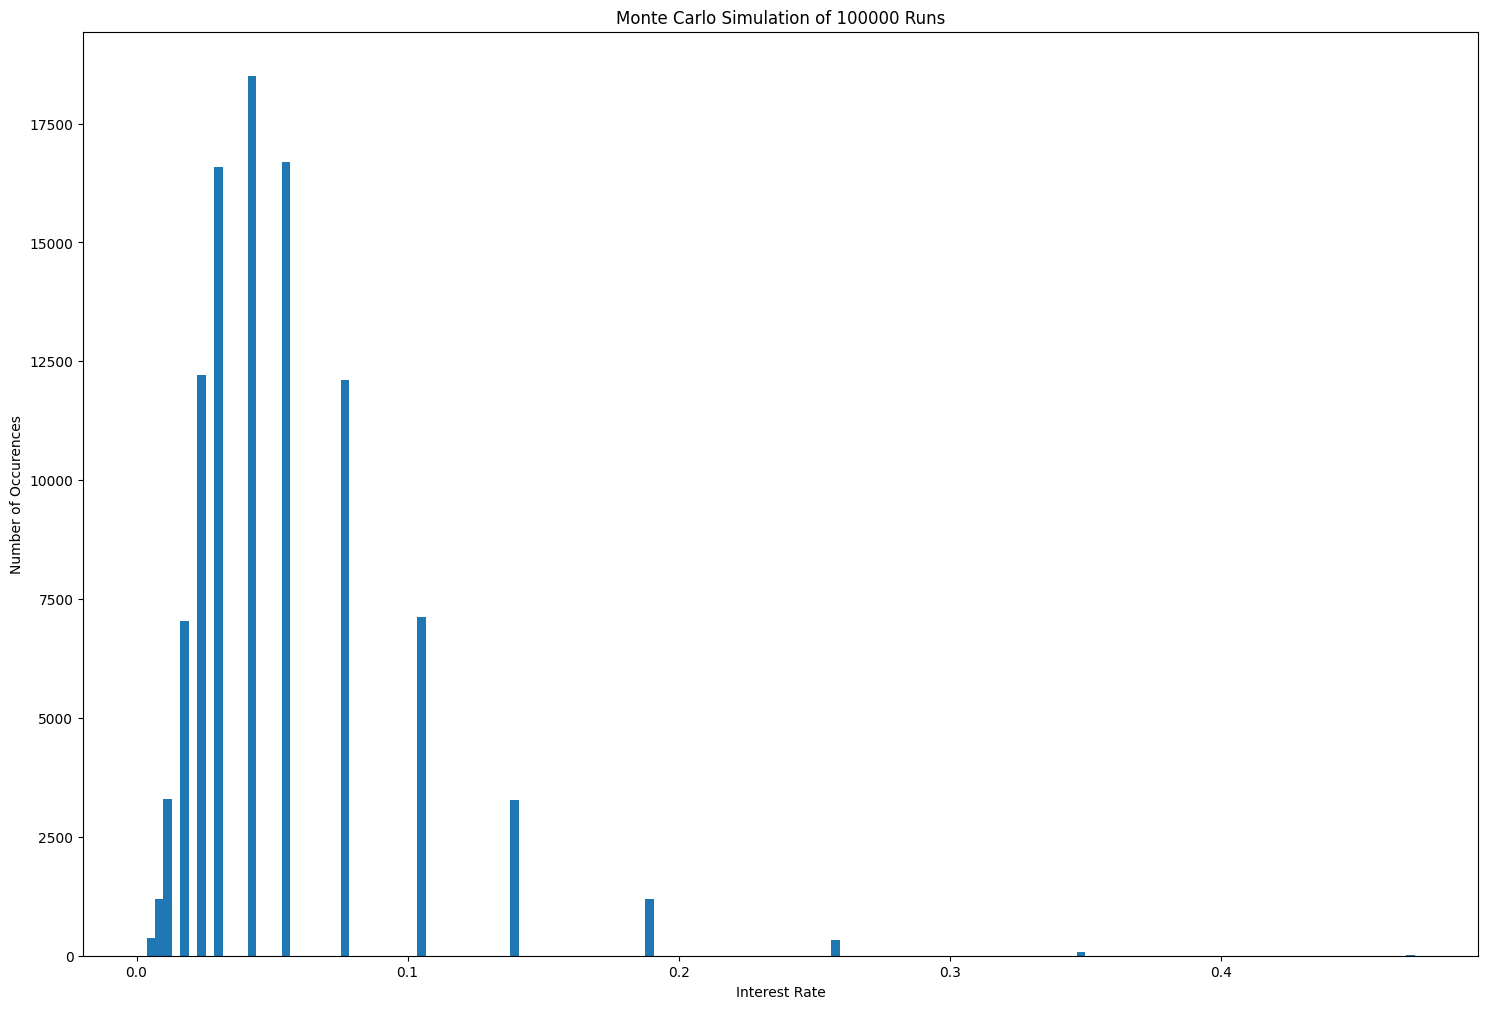

In [39]:
MC_BDT_Realisations.plot.hist(
    figsize = (18, 12),
    xlabel = 'Interest Rate',
    ylabel= 'Number of Occurences',
    bins=150,
    title = f'Monte Carlo Simulation of {N} Runs')

### Fixed Mortgage MC (Qe)

In [40]:
N = 100000
BDT_Mortgage_Tree_Prepay_Option, BDT_Mortgage_Tree_NoPrepay, x = mortgage_value_prepay(rate = BDT_Par_Rate, periods = 19, binomial_tree=BDT_Tree)
Bx, interest_paid, principal_paid, outstanding_principal, coupon = mortgage_value_no_prepay(rate = BDT_Par_Rate, periods = 19, binomial_tree=BDT_Tree)

def monte_carlo_simulation_Mortgage(
        mortgage_tree_prepay=BDT_Mortgage_Tree_Prepay_Option,
        mortgage_tree_no_prepay = BDT_Mortgage_Tree_NoPrepay,
        interest_schedule = interest_paid,
        principal_schedule = principal_paid,
        interest_rate_tree=BDT_Tree,
        balance = outstanding_principal,
        paths=100000, dt = dt):
    
    #Creating initial simulation matrices
    periods = mortgage_tree_no_prepay.shape[0]
    simulation_no_prepay = np.zeros([paths, periods+1])
    simulation_prepay = np.zeros([paths, periods+1])
    #Store coefficients => Log-Sum-Exp trick to overcome underflow error
    log_discount_factor = np.zeros([paths, periods])

    for path in range(paths):
        state = 0
        log_discount_factor[path, 0] = 0 #log(1) = 0
        break_loop = False 
        for period in range(1, periods): #Loops over periods from i = 0 to T

            #Step 1. Random Engine to simulate up or down move
            p = np.random.rand()
            if p > 0.5: #Up move (j)
                pass
            else: #Down Move (j + 1)
                state = state + 1

            
            #Step 1. Total Cash Flow of Contract
            total_cash_flows = interest_schedule[period] + principal_schedule[period] #Sums total cash flows to be discounted for each period
            #Step 2. Calculate and apply discount factor to cash flows up to this period
            log_discount_factor[path, period] = log_discount_factor[path, period - 1] - dt*interest_rate_tree[state, period]

            #Step 2a. Expontentiate discount factor 
            simulation_no_prepay[path, period] = total_cash_flows * np.exp(log_discount_factor[path, period])
 
            #Prepayment Option Stuff
            mortgage_value = mortgage_tree_prepay[state, period]

            #Note : prepayment logic 
            if break_loop == False:
                if mortgage_value == 0:
                    break_loop = True
                    simulation_prepay[path, period] = balance[period-1] * np.exp(log_discount_factor[path, period])
                else:
                    simulation_prepay[path, period] = total_cash_flows * np.exp(log_discount_factor[path, period])
            

    return simulation_no_prepay, simulation_prepay, log_discount_factor
    

In [41]:
#Running the MC at BDT Par Rate
sim_no_prepay, sim_prepay, df = monte_carlo_simulation_Mortgage(paths = N)

In [42]:
#MC Result of Mortgage Contract without Prepay Option
MC_Sim_Optimal_No_Prepay = np.mean(sim_no_prepay, axis = 0).sum() 
MC_Sim_Optimal_No_Prepay

np.float64(106328.14947135569)

In [43]:
#MC Result of the Value of the Option
MC_Sim_Optimal_Option_Value = np.mean(sim_prepay, axis = 0).sum() - 100000
MC_Sim_Optimal_Option_Value

np.float64(6285.480072548016)

In [44]:
#Confidence Interval of Mortgage Contract (no prepay)
SE_Optimal_No_Prepay = np.std(np.sum(sim_no_prepay, axis = 1)) / np.sqrt(10000)
ConfidenceInterval_Optimal_No_Prepay = [np.mean(sim_no_prepay, axis = 0).sum() - 2*SE_Optimal_No_Prepay*2, np.mean(sim_no_prepay, axis = 0).sum() + 2* SE_Optimal_No_Prepay]

#Confidence Interval of value of the Option to prepay 
SE_Optimal_Option = np.std(sim_prepay.sum(axis=1) - 100000) / np.sqrt(10000)
ConfidenceInterval_Optimal_Option = [np.mean(sim_prepay, axis = 0).sum() - SE_Optimal_Option*2 - 100000, np.mean(sim_prepay, axis = 0).sum() + SE_Optimal_Option*2 - 100000]

print('Confidence Interval for No Prepay:', ConfidenceInterval_Optimal_No_Prepay,
      '\nConfidence Interval for Prepay: ', ConfidenceInterval_Optimal_Option)

Confidence Interval for No Prepay: [np.float64(106101.09524777232), np.float64(106441.67658314737)] 
Confidence Interval for Prepay:  [np.float64(6175.731840726017), np.float64(6395.228304370015)]


In [45]:
print(f'Mortgage Value (no prepay) via Backward Induction : {mortgage_value_prepay(rate = BDT_Par_Rate, periods = 20, binomial_tree=BDT_Tree)[1][0,0]}')
print(f'Value of Prepay Option via Backward Induction : {mortgage_value_prepay(rate = BDT_Par_Rate, periods = 20, binomial_tree=BDT_Tree)[0][0,0]}')
print(f'Mortgage Value (no prepay) via Backward Induction : {mortgage_value_no_prepay(rate = BDT_Par_Rate, periods = 20, binomial_tree=BDT_Tree)[0][0,0] - mortgage_value_prepay(rate=BDT_Par_Rate, periods = 20, binomial_tree = BDT_Tree)[0][0,0]}')

Mortgage Value (no prepay) via Backward Induction : 106204.03901667299
Value of Prepay Option via Backward Induction : 6204.039016672992
Mortgage Value (no prepay) via Backward Induction : 100000.0


### Suboptimal Prepayment



In [46]:
def monte_carlo_suboptimal_prepay(
        mortgage_tree_prepay=BDT_Mortgage_Tree_Prepay_Option,
        mortgage_tree_no_prepay = BDT_Mortgage_Tree_NoPrepay,
        interest_schedule = interest_paid,
        principal_schedule = principal_paid,
        interest_rate_tree=BDT_Tree,
        balance = outstanding_principal,
        paths=10000, dt = dt):
    
    #Creating initial simulation matrices
    periods = mortgage_tree_no_prepay.shape[0]
    simulation_no_prepay = np.zeros([paths, periods+1])
    simulation_prepay = np.zeros([paths, periods+1])
    #Store coefficients => Log-Sum-Exp trick to overcome underflow error
    log_discount_factor = np.zeros([paths, periods])

    for path in range(paths):
        state = 0
        log_discount_factor[path, 0] = 0 #log(1) = 0
        season_index = 1
        break_loop = False 
        for period in range(1, periods): #Loops over periods from i = 0 to T

            #Set-up Suboptimal prepayment conditions/rules

            Conditional_Prepayment_Rate  = min( 12 * period * dt * 0.2, 0.6)
            if period % 2 == 0:
                season_index = 2
            else:
                season_index = 1

            probability_prepay = season_index * (1- (1-(0.5*Conditional_Prepayment_Rate))**dt)



            #Step 1. Random Engine to simulate up or down move
            p = np.random.rand()
            if p > 0.5: #Up move (j)
                pass
            else: #Down Move (j + 1)
                state = state + 1

            
            #Step 1. Total Cash Flow of Contract
            total_cash_flows = interest_schedule[period] + principal_schedule[period] #Sums total cash flows to be discounted for each period
            #Step 2. Calculate and apply discount factor to cash flows up to this period
            log_discount_factor[path, period] = log_discount_factor[path, period - 1] - dt*interest_rate_tree[state, period]

            #Step 2a. Expontentiate discount factor 
            simulation_no_prepay[path, period] = total_cash_flows * np.exp(log_discount_factor[path, period])
 
            #Prepayment Option Stuff
            mortgage_value = mortgage_tree_prepay[state, period]

            #Note : prepayment logic 
            if break_loop == False:
                if mortgage_value == 0:
                    #Set-up Suboptimal non-prepayment conditions/rules
                    probability_no_prepay = 0.8 * np.exp(20 * interest_rate_tree[state, period])
                    #Suboptimal no prepayment
                    if p < probability_no_prepay:
                        #print(probability_no_prepay, p, 'no prepay')
                        break_loop = True
                        simulation_prepay[path, period] = balance[period-1] * np.exp(log_discount_factor[path, period])
                    else:
                        simulation_prepay[path, period] = total_cash_flows * np.exp(log_discount_factor[path, period])
                else:
                    #Suboptimal Prepayment
                    if probability_prepay > p:
                        break_loop = True
                        simulation_prepay[path, period] = balance[period -1] * np.exp(log_discount_factor[path, period])
                    else:
                        simulation_prepay[path, period] = total_cash_flows * np.exp(log_discount_factor[path, period])

    return simulation_no_prepay, simulation_prepay, log_discount_factor

N = 100000
sim_suboptimal_no_prepay, sim_suboptimal_prepay, sim_suboptimal_df = monte_carlo_suboptimal_prepay(paths = N)
    

In [47]:
#Value of the fixed rate contract with no option to prepay
MC_Sim_Suboptimal_No_Prepay_Value = sim_suboptimal_no_prepay.sum(axis=1).mean()
#Value of mortgage contract under suboptimal prepayment assumptions
MC_Sim_Suboptimal_Prepay_Value = sim_suboptimal_prepay.sum(axis=1).mean()
#Value of the option to prepay under suboptimal prepayment assumptions
MC_Sim_Suboptimal_Option_Value = -MC_Sim_Suboptimal_No_Prepay_Value + MC_Sim_Suboptimal_Prepay_Value

#Conf. Interval for the Value of Mortgage Contract with Prepayment Option (to UBS)
SE_suboptimal_prepay = np.std(sim_suboptimal_prepay) / np.sqrt(N)
ConfidenceInterval_suboptimal_prepay = [ MC_Sim_Suboptimal_Prepay_Value- 2*SE_suboptimal_prepay, MC_Sim_Suboptimal_Prepay_Value + 2*SE_suboptimal_prepay] 

print('Point Estimate for Contract Value (No Prepay):', MC_Sim_Suboptimal_No_Prepay_Value,
      '\nPoint Estimate for Value of Option to Prepay: ', MC_Sim_Suboptimal_Option_Value,
      '\nPoint Estimate for Value of Mortgage Contract (with Prepay)', MC_Sim_Suboptimal_Prepay_Value)


print('\nConfidence Interval for No Prepay:', ConfidenceInterval_suboptimal_prepay,
      '\nConfidence Interval for Prepay: ', ConfidenceInterval_Optimal_Option,
      '\nConfidence Interval for Overall Contract Value: ', [ConfidenceInterval_suboptimal_prepay[i] - ConfidenceInterval_Optimal_Option[i] - 100000 for i in range(2)])


Point Estimate for Contract Value (No Prepay): 106332.430227695 
Point Estimate for Value of Option to Prepay:  -6780.06493414838 
Point Estimate for Value of Mortgage Contract (with Prepay) 99552.36529354662

Confidence Interval for No Prepay: [np.float64(99441.9456611526), np.float64(99662.78492594065)] 
Confidence Interval for Prepay:  [np.float64(6175.731840726017), np.float64(6395.228304370015)] 
Confidence Interval for Overall Contract Value:  [np.float64(-6733.786179573421), np.float64(-6732.443378429365)]


### MBS 

In [62]:
PTS_BDT_Interest_Schedule, PTS_BDT_Principal_Schedule, PTS_BDT_Outstanding_Balance, PTS_BDT_Coupon = PTS_mortgage_amortisation_schedule(rate = BDT_Par_Rate, pass_through_rate=BDT_PTS_Rate, N = 20, principal = 100000)
PTS_ValueTree, IO_ValueTree, PO_ValueTree = PTS_Value_Tree(rate = BDT_Par_Rate, pass_through_rate= BDT_PTS_Rate, binomial_tree=BDT_Tree, periods = 20)
boolean_mask_prepay = mortgage_value_prepay(rate = BDT_Par_Rate, periods = 20, binomial_tree=BDT_Tree)[2]

In [ ]:
def monte_carlo_simulation_PTS(
        prepay_mask = boolean_mask_prepay,
        interest_schedule = PTS_BDT_Interest_Schedule,
        principal_schedule = PTS_BDT_Principal_Schedule,
        outstanding_balance = PTS_BDT_Outstanding_Balance, 
        paths=100000, dt=dt, interest_rate_tree=BDT_Tree):
    
    #Creating initial simulation matrices
    periods = interest_schedule.shape[0] 
    simulation_PTS = np.zeros([paths, periods])
    simulation_IO = np.zeros([paths, periods])
    simulation_PO = np.zeros([paths, periods])

    #Store coefficients => Log-Sum-Exp trick to overcome underflow error
    log_discount_factor = np.zeros([paths, periods])
    prepay_mask[0,0] = 0

    for path in range(paths):
        state = 0
        log_discount_factor[path, 0] = 0 #log(1) = 0
        prepaid = False 
        for period in range(1, periods-1): 
            #Prepay Probability (Assumption 1)
            Conditional_Prepayment_Rate  = min( 12 * period * dt * 0.2, 0.6)
            if period % 2 == 0:
                season_index = 2
            else:
                season_index = 1

            probability_prepay = season_index * (1- (1-(0.5*Conditional_Prepayment_Rate))**dt)

            #Random Engine to simulate up or down move
            p = np.random.rand()
            if p > 0.5: #Up move (j)
                pass
            else: #Down Move (j + 1)
                state = state + 1

            #Step 1: Setting Up Cash Flows 
            PTS_Cash_Flows = interest_schedule[period] + principal_schedule[period]
            IO_Cash_Flows = interest_schedule[period]
            PO_Cash_Flows = principal_schedule[period]

            #Step 2. Calculate and apply discount factor to cash flows up to this period
            log_discount_factor[path, period] = log_discount_factor[path, period - 1] - dt*interest_rate_tree[state, period]

            #Step 3. Prepayment Logic
            if prepaid == False:
                #Use Boolean Mask to Determine Prepaid
                if prepay_mask[state, period] == 1:
                    #Suboptimal non-prepayment condition
                    probability_no_prepay = 0.8 * np.exp(20 * interest_rate_tree[state, period])
                    #If early exercise happens
                    if p < probability_no_prepay:
                        prepaid = True
                        #PTS Cash Flows is outstanding balance + coupon from prior period
                        simulation_PTS[path, period] = (outstanding_balance[period-1] + interest_schedule[period])* np.exp(log_discount_factor[path, period])
                        #PTS Cash Flows is zero thereafter
                        simulation_PTS[path, period + 1:] = 0
                        #Interest Only Strip only receives cash flows from prior period 
                        simulation_IO[path, period] = interest_schedule[period] * np.exp(log_discount_factor[path, period])
                        #Interest Only Strip cash flows is zero thereafter 
                        simulation_IO[path, period + 1:] = 0
                        #Principal Only strip receives the balance outstanding 
                        simulation_PO[path, period] = outstanding_balance[period-1] * np.exp(log_discount_factor[path, period])
                        #Principal Only cash flow is zero thereafter
                        simulation_PO[path, period+1:] = 0
                    
                    #If early exercise doesn't happen 
                    else:
                        #Set period's cash flows for each security
                        simulation_PTS[path, period] = PTS_Cash_Flows * np.exp(log_discount_factor[path, period])
                        simulation_IO[path, period] = IO_Cash_Flows * np.exp(log_discount_factor[path, period])
                        simulation_PO[path, period] = PO_Cash_Flows * np.exp(log_discount_factor[path, period])
            

                else:
                    #Suboptimal Prepayment Logic
                    if probability_prepay > p:
                        prepaid = True
                        simulation_PTS[path, period] = (outstanding_balance[period-1] + interest_schedule[period])* np.exp(log_discount_factor[path, period])
                        simulation_PTS[path, period + 1:] = 0
                        simulation_IO[path, period] = interest_schedule[period] * np.exp(log_discount_factor[path, period])
                        simulation_IO[path, period + 1:] = 0
                        simulation_PO[path, period] = outstanding_balance[period-1] * np.exp(log_discount_factor[path, period])
                        simulation_PO[path, period+1:] = 0
                    else:
                        #Set period's cash flows for each security
                        simulation_PTS[path, period] = PTS_Cash_Flows * np.exp(log_discount_factor[path, period])
                        simulation_IO[path, period] = IO_Cash_Flows * np.exp(log_discount_factor[path, period])
                        simulation_PO[path, period] = PO_Cash_Flows * np.exp(log_discount_factor[path, period])
            

    return simulation_PTS, simulation_IO, simulation_PO



In [ ]:
N = 100000
sim_PTS, sim_IO, sim_PO = monte_carlo_simulation_PTS(paths=N)

In [ ]:
#Value of the PTS via Monte Carlo 
MC_Sim_PTS_Value = np.sum(sim_PTS, axis = 1).mean()
StdError_PTS = np.std(sim_PTS) / np.sqrt(N)
MC_Sim_PTS_CI = [MC_Sim_PTS_Value - 2*StdError_PTS, MC_Sim_PTS_Value + 2*StdError_PTS] 
#Value of the Interest Only Strip
MC_Sim_IO_Value = np.sum(sim_IO, axis =1).mean()
StdError_IO = np.std(sim_IO) / np.sqrt(N)
MC_Sim_IO_CI = [MC_Sim_IO_Value - 2*StdError_IO, MC_Sim_IO_Value + 2*StdError_IO] 
#Value of the Principal Only Strip
MC_Sim_PO_Value = np.sum(sim_PO, axis = 1).mean()
StdError_PO = np.std(sim_PO) / np.sqrt(N)
MC_Sim_PO_CI = [MC_Sim_PO_Value - 2*StdError_PO, MC_Sim_PO_Value + 2*StdError_PO] 


In [ ]:

print('Point Estimate for PTS): ', MC_Sim_PTS_Value,
      '\nPoint Estimate for IO Strip: ', MC_Sim_IO_Value,
      '\nPoint Estimate for PO Strip: ', MC_Sim_PO_Value)

print('\nConfidence Interval for PTS: ', MC_Sim_PTS_CI,
      '\nConfidence Interval for IO Strip: ', MC_Sim_IO_CI,
      '\nConfidence Interval for PO Strip: ', MC_Sim_PO_CI)

Point Estimate for PTS):  100076.51161842005 
Point Estimate for IO Strip:  4681.05930995567 
Point Estimate for PO Strip:  95395.45230846437

Confidence Interval for PTS:  [np.float64(99951.1239251462), np.float64(100201.8993116939)] 
Confidence Interval for IO Strip:  [np.float64(4677.058213842479), np.float64(4685.060406068861)] 
Confidence Interval for PO Strip:  [np.float64(95272.82675032313), np.float64(95518.07786660561)]
